## Load Data From Google Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Without Scores Only Stock Price (Univariate): ◀

## Custom Dataset Class For Stocks

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import random

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}")

# Example: Setting the seed
set_seed(123)

def time_aware_r2(y_true, y_pred, start_t=12):
    assert len(y_true) == len(y_pred), "Lengths must match"

    model_sq_errors = []
    naive_sq_errors = []

    for t in range(start_t, len(y_true)):
        hist_mean = np.mean(y_true[:t])              # mean of past true values
        model_error = (y_true[t] - y_pred[t]) ** 2    # LSTM prediction error
        naive_error = (y_true[t] - hist_mean) ** 2    # historical mean error

        model_sq_errors.append(model_error)
        naive_sq_errors.append(naive_error)

    numerator = np.sum(model_sq_errors)
    denominator = np.sum(naive_sq_errors)

    if denominator == 0:
        return 0.0  # Avoid division by zero; degenerate case

    r2 = 1 - numerator / denominator
    return r2


# Load and preprocess the data
class StockDataset(Dataset):
    def __init__(self, prices, seq_length=10):
        self.prices     = prices
        self.seq_length = seq_length

    def __len__(self):
        return len(self.prices) - self.seq_length - 12

    def __getitem__(self, idx):
        x        = self.prices[idx : idx + self.seq_length]
        y        = (self.prices[idx + self.seq_length + 12])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def preprocess_data(csv_path, cut_off_1, cut_off_2,  test_one_start, test_two_end, seq_length=10):
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    scaler = MinMaxScaler()
    df['scaled_price'] = scaler.fit_transform(df[['price']])

    # Split the dataset
    train_data = df[df['timestamp'] < cut_off_1]['scaled_price'].values

    val_data = df[(df['timestamp'] >= test_one_start) & (df['timestamp'] < cut_off_2)]['scaled_price'].values
    test_data = df[(df['timestamp'] >= cut_off_2) & (df['timestamp'] < test_two_end)]['scaled_price'].values

    train_dataset = StockDataset(train_data, seq_length)
    val_dataset = StockDataset(val_data, seq_length)
    test_dataset = StockDataset(test_data, seq_length)

    return train_dataset, val_dataset, test_dataset, scaler

Seeds set to 123


## Model Architecture

In [ ]:
# Define the RNN model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # Take the output of the last time step
        output = self.fc(output)
        return output

## Training Loop

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    model.to(device)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                predictions = model(x)
                loss = criterion(predictions.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

## Testing Loop (Input Actual Price)

In [ ]:
def test_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            prediction = model(x).squeeze().cpu().numpy()
            predictions.append(prediction)
            actuals.append(y.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    predicted_prices_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual_prices_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    mse = mean_squared_error(actual_prices_original, predicted_prices_original)
    mae = mean_absolute_error(actual_prices_original, predicted_prices_original)
    r2 = time_aware_r2(actual_prices_original, predicted_prices_original)


    print(f"Test Metrics: MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    return predictions, actuals


## Execution Starts Here

Epoch 1/600, Train Loss: 0.0017, Val Loss: 0.1065
Epoch 2/600, Train Loss: 0.0009, Val Loss: 0.1115
Epoch 3/600, Train Loss: 0.0006, Val Loss: 0.1153
Epoch 4/600, Train Loss: 0.0004, Val Loss: 0.1179
Epoch 5/600, Train Loss: 0.0003, Val Loss: 0.1194
Epoch 6/600, Train Loss: 0.0003, Val Loss: 0.1201
Epoch 7/600, Train Loss: 0.0003, Val Loss: 0.1204
Epoch 8/600, Train Loss: 0.0003, Val Loss: 0.1206
Epoch 9/600, Train Loss: 0.0003, Val Loss: 0.1204
Epoch 10/600, Train Loss: 0.0003, Val Loss: 0.1203
Epoch 11/600, Train Loss: 0.0003, Val Loss: 0.1202
Epoch 12/600, Train Loss: 0.0003, Val Loss: 0.1201
Epoch 13/600, Train Loss: 0.0003, Val Loss: 0.1200
Epoch 14/600, Train Loss: 0.0003, Val Loss: 0.1199
Epoch 15/600, Train Loss: 0.0003, Val Loss: 0.1198
Epoch 16/600, Train Loss: 0.0003, Val Loss: 0.1196
Epoch 17/600, Train Loss: 0.0003, Val Loss: 0.1195
Epoch 18/600, Train Loss: 0.0003, Val Loss: 0.1193
Epoch 19/600, Train Loss: 0.0003, Val Loss: 0.1192
Epoch 20/600, Train Loss: 0.0003, Val Lo

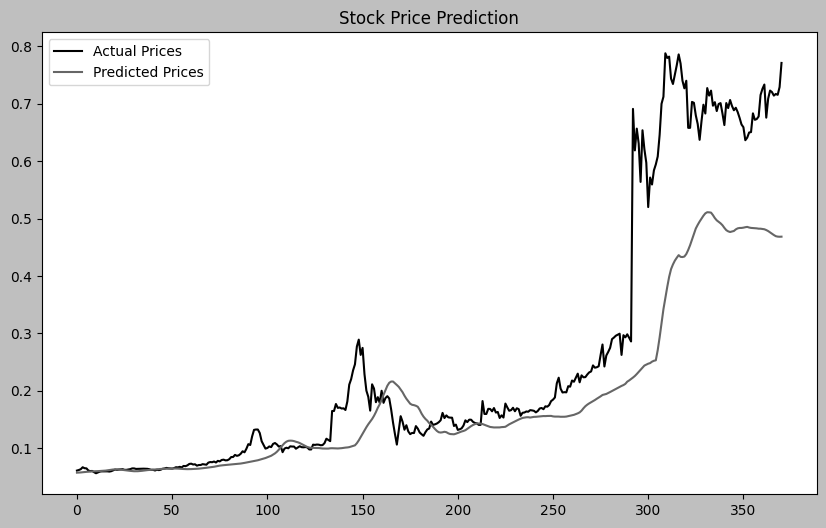

After 2021-01-28 00:00:00
Test Metrics: MSE: 229.1919, MAE: 11.4478, R^2: 0.5584


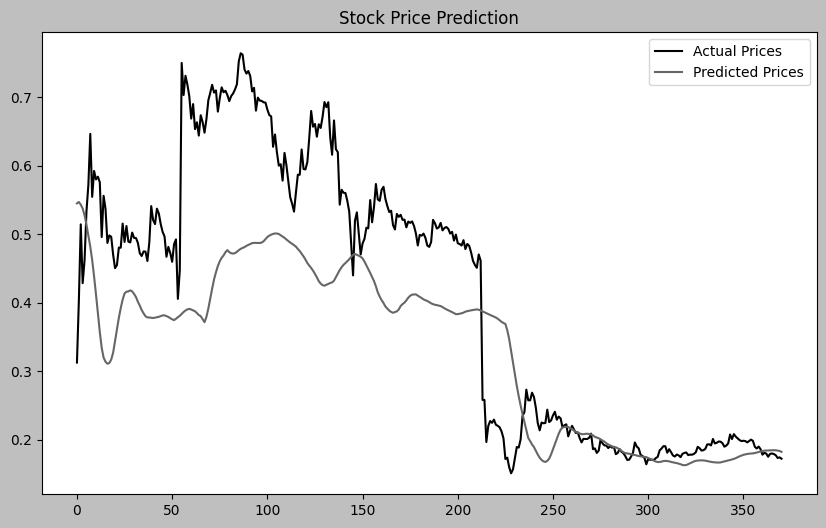

In [ ]:
# Main script
if __name__ == "__main__":
    # File path and cut-offs
    csv_path  = "drive/MyDrive/StockGME/combined_5min_stockdata.csv"

    # Relevant cutoffs
    # test_one_start= "2021-01-22 00:00:00"
    # test_two_end  = "2021-02-08 00:00:00"

    test_one_start= "2021-01-21 00:00:00"
    test_two_end  = "2021-02-04 00:00:00"

    cut_off_1     = "2021-01-21 00:00:00"
    cut_off_2     = "2021-01-28 00:00:00"

    # Hyperparameters
    seq_length    = 12
    batch_size    = 32
    learning_rate = 0.00001
    num_epochs    = 600
    device        = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Prepare datasets and dataloaders
    train_dataset, val_dataset, test_dataset, scaler = preprocess_data(csv_path, cut_off_1, cut_off_2, test_one_start, test_two_end, seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, and optimizer
    model     = StockPriceRNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and validate the model
    train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

    # Test the model
    print(f"Between {cut_off_1} and {cut_off_2}")
    predictions, actuals = test_model(model, val_loader, device)

    predicted_prices_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual_prices_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices")
    plt.legend()
    plt.title("Stock Price Prediction")
    plt.show()

    # Test the model
    print(f"After {cut_off_2}")
    predictions1, actuals1 = test_model(model, test_loader, device)

    predicted_prices_original1 = scaler.inverse_transform(predictions1.reshape(-1, 1)).flatten()
    actual_prices_original1 = scaler.inverse_transform(actuals1.reshape(-1, 1)).flatten()

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actuals1, label="Actual Prices")
    plt.plot(predictions1, label="Predicted Prices")
    plt.legend()
    plt.title("Stock Price Prediction")
    plt.show()


Between 2021-01-21 00:00:00 and 2021-01-28 00:00:00
Test Metrics: MSE: 224.6786, MAE: 8.8453, R^2: 0.6819
After 2021-01-28 00:00:00
Test Metrics: MSE: 229.1919, MAE: 11.4478, R^2: 0.5584


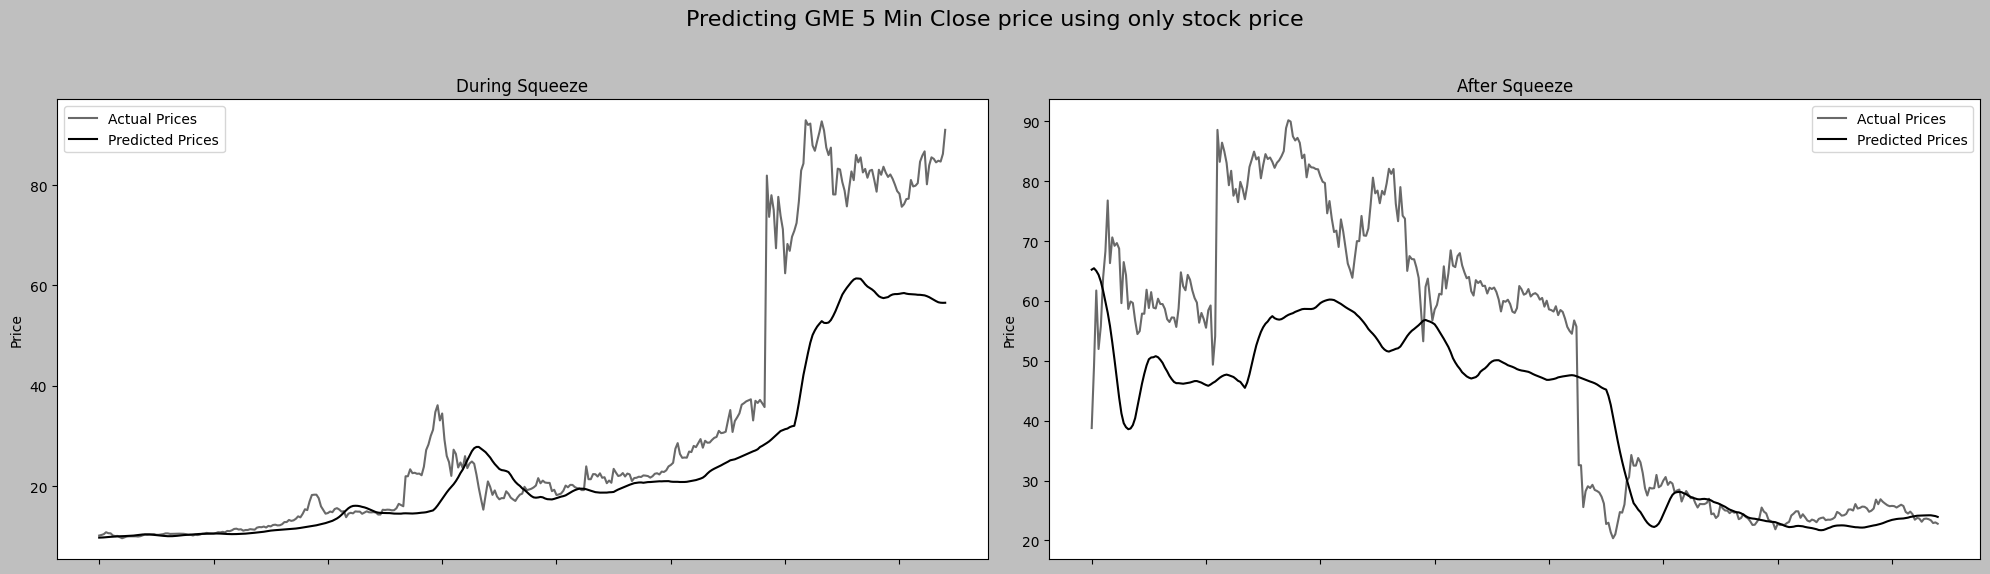

In [ ]:
# Test the model
print(f"Between {cut_off_1} and {cut_off_2}")
predictions, actuals = test_model(model, val_loader, device)
predicted_prices_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_prices_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

 # Test the model
print(f"After {cut_off_2}")
predictions1, actuals1 = test_model(model, test_loader, device)
predicted_prices_original1 = scaler.inverse_transform(predictions1.reshape(-1, 1)).flatten()
actual_prices_original1 = scaler.inverse_transform(actuals1.reshape(-1, 1)).flatten()


plt.style.use('grayscale')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(
    "Predicting GME 5 Min Close price using only stock price",
    fontsize=16
)

# Fig 1: During Squeeze (index on x‑axis)
axes[0].plot(actual_prices_original,    label="Actual Prices",    color="dimgray")
#axes[0].plot(np.arange(len(predicted_prices_original)) - 12,predicted_prices_original, label="Predicted Prices", color="black")
axes[0].plot(predicted_prices_original, label="Predicted Prices", color="black")
axes[0].set_title("During Squeeze")
axes[0].set_ylabel("Price")
axes[0].set_xticklabels([])
axes[0].legend()

# Fig 2: After Squeeze (index on x‑axis)
axes[1].plot(actual_prices_original1,    label="Actual Prices",    color="dimgray")
#axes[1].plot(np.arange(len(predicted_prices_original1)) - 12,predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].plot(predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].set_title("After Squeeze")
axes[1].set_ylabel("Price")
axes[1].set_xticklabels([])
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# With scores and activity along with stock price (Multivariate) ◀

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import random

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}")

# Example: Setting the seed
set_seed(42)

def time_aware_r2(y_true, y_pred, start_t=12):
    assert len(y_true) == len(y_pred), "Lengths must match"

    model_sq_errors = []
    naive_sq_errors = []

    for t in range(start_t, len(y_true)):
        hist_mean = np.mean(y_true[:t])              # mean of past true values
        model_error = (y_true[t] - y_pred[t]) ** 2    # LSTM prediction error
        naive_error = (y_true[t] - hist_mean) ** 2    # historical mean error

        model_sq_errors.append(model_error)
        naive_sq_errors.append(naive_error)

    numerator = np.sum(model_sq_errors)
    denominator = np.sum(naive_sq_errors)

    if denominator == 0:
        return 0.0  # Avoid division by zero; degenerate case

    r2 = 1 - numerator / denominator
    return r2

# <|-----1hour stock price----|----1 hours reddit scores ------||--0hour--| => |-stock price after <2 hours-|

# Dataset class for stock prices and scores
class StockDatasetWithScores(Dataset):
    def __init__(self, data, seq_length=10):
        self.prices     = data['scaled_price'].values
        self.scores     = data['scaled_score'].values
        self.seq_length = seq_length

    def __len__(self):
        return len(self.prices) - self.seq_length - 12

    def __getitem__(self, idx):
        x_prices = self.prices[idx : idx + self.seq_length]
        x_scores = self.scores[idx + self.seq_length : idx + self.seq_length + 12]
        y        = (self.prices[idx + self.seq_length + 12])
        x        = (np.concatenate((x_scores, x_prices), axis=0))
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), []

# Preprocess data to merge stock prices and scores
def preprocess_data_with_scores(stock_csv, scores_csv, cut_off_1, cut_off_2, test_one_start, test_two_end, seq_length=10):
    # Load stock prices
    stock_df = pd.read_csv(stock_csv)
    print(stock_df.columns)

    stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])
    stock_df = stock_df.sort_values('timestamp')

    # Load scores
    scores_df = pd.read_csv(scores_csv)
    scores_df['timestamp'] = pd.to_datetime(scores_df['timestamp'])
    scores_df = scores_df.sort_values('timestamp')

    # Merge stock prices and scores
    merged_df = pd.merge_asof(stock_df, scores_df, on='timestamp', direction='backward')

    # Scale stock prices and scores
    scaler_price = MinMaxScaler()
    scaler_score = MinMaxScaler()
    merged_df['scaled_price'] = scaler_price.fit_transform(merged_df[['price']])
    print(merged_df.columns)
    #merged_df['scaled_score'] = scaler_score.fit_transform(merged_df[['sum_num_comments']])
    merged_df['scaled_score'] = scaler_score.fit_transform(merged_df[['max_score']]) ########

    # Split into training, validation, and testing
    train_data = merged_df[merged_df['timestamp'] < cut_off_1]
    val_data = merged_df[(merged_df['timestamp'] >= test_one_start) & (merged_df['timestamp'] < cut_off_2)]
    test_data = merged_df[(merged_df['timestamp'] >= cut_off_2) & (merged_df['timestamp'] < test_two_end)]

    # Create datasets
    train_dataset = StockDatasetWithScores(train_data, seq_length)
    val_dataset = StockDatasetWithScores(val_data, seq_length)
    test_dataset = StockDatasetWithScores(test_data, seq_length)

    return train_dataset, val_dataset, test_dataset, scaler_price, scaler_score

Seeds set to 42


In [ ]:
# Define the RNN model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # Use the last time step's output
        output = self.fc(output)
        return output


In [ ]:

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    model.to(device)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.to(device), y.to(device)
                predictions = model(x)
                loss = criterion(predictions.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

In [ ]:
def test_model_multivariate(model, test_loader, seq_length, scaler, device='cpu'):
    model.to(device)
    model.eval()
    predictions = []
    actuals = []
    inputs = []

    with torch.no_grad():
        for x, y, norm in test_loader:
            x, y = x.to(device), y.to(device)
            predicted = model(x)
            predicted = predicted.squeeze().cpu().numpy()
            predictions.extend(predicted)
            actuals.extend(y.cpu().numpy())
            inputs.extend(x.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    predicted_prices_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual_prices_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    mse = mean_squared_error(actual_prices_original, predicted_prices_original)
    mae = mean_absolute_error(actual_prices_original, predicted_prices_original)
    r2 = time_aware_r2(actual_prices_original, predicted_prices_original)

    print(f"Non-Autoregressive Test Metrics: MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    return predictions, actuals


Index(['timestamp', 'BBY_Close', 'FCFS_Close', 'IWM_Close', 'ODP_Close',
       'SPX_Close', 'price', 'BBY_5min_return', 'FCFS_5min_return',
       'IWM_5min_return', 'ODP_5min_return', 'SPX_5min_return',
       'GME_5min_return'],
      dtype='object')
Index(['timestamp', 'BBY_Close', 'FCFS_Close', 'IWM_Close', 'ODP_Close',
       'SPX_Close', 'price', 'BBY_5min_return', 'FCFS_5min_return',
       'IWM_5min_return', 'ODP_5min_return', 'SPX_5min_return',
       'GME_5min_return', 'sum_score', 'max_score', 'avg_score',
       'sum_num_comments', 'scaled_price'],
      dtype='object')
Epoch 1/600, Train Loss: 0.0138, Val Loss: 0.1856
Epoch 2/600, Train Loss: 0.0104, Val Loss: 0.1750
Epoch 3/600, Train Loss: 0.0076, Val Loss: 0.1654
Epoch 4/600, Train Loss: 0.0054, Val Loss: 0.1566
Epoch 5/600, Train Loss: 0.0036, Val Loss: 0.1486
Epoch 6/600, Train Loss: 0.0023, Val Loss: 0.1417
Epoch 7/600, Train Loss: 0.0014, Val Loss: 0.1359
Epoch 8/600, Train Loss: 0.0009, Val Loss: 0.1312
Epoch 9/60

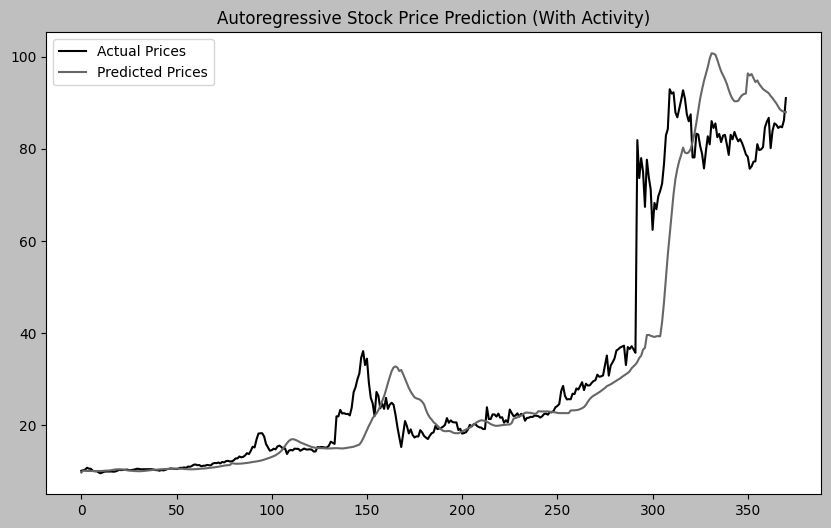

After 2021-01-28 00:00:00
Non-Autoregressive Test Metrics: MSE: 234.1108, MAE: 10.4218, R^2: 0.6419


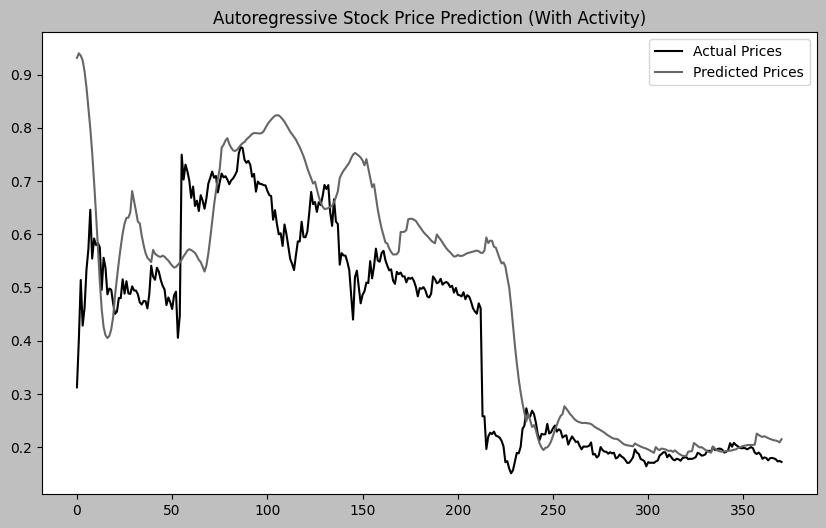

In [ ]:
# Main script
if __name__ == "__main__":
    # File paths
    stock_csv     = "drive/MyDrive/StockGME/combined_5min_stockdata.csv"
    scores_csv    = "drive/MyDrive/StockGME/aggregated_scores_by_5min_bhavin.csv"

    # Relevant cutoffs
    test_one_start= "2021-01-21 00:00:00"
    test_two_end  = "2021-02-04 00:00:00"

    cut_off_1     = "2021-01-21 00:00:00"
    cut_off_2     = "2021-01-28 00:00:00"

    # Hyperparameters
    seq_length    = 12
    batch_size    = 32
    learning_rate = 0.00001
    num_epochs    = 600
    device        = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Prepare datasets and dataloaders
    train_dataset, val_dataset, test_dataset, scaler_price, scaler_score = preprocess_data_with_scores(
        stock_csv, scores_csv, cut_off_1, cut_off_2, test_one_start, test_two_end, seq_length)

    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, and optimizer
    model         = StockPriceRNN(input_size=1)  # Input size is 2: stock prices and scores
    criterion     = nn.MSELoss()
    optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and validate the model
    train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

    # Test the model non autoregressively
    print(f"Between {cut_off_1} and {cut_off_2}")
    predicted_prices_original, actual_prices_original = test_model_multivariate(
        model, val_loader, seq_length, scaler_price, device)

    # Reverse the scaling
    predicted_prices_original = scaler_price.inverse_transform(predicted_prices_original.reshape(-1, 1)).flatten()
    actual_prices_original    = scaler_price.inverse_transform(actual_prices_original.reshape(-1, 1)).flatten()

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices_original, label="Actual Prices")
    plt.plot(predicted_prices_original, label="Predicted Prices")
    plt.legend()
    plt.title("Autoregressive Stock Price Prediction (With Activity)")
    plt.show()


    print(f"After {cut_off_2}")
    predicted_prices_original1, actual_prices_original1 = test_model_multivariate(
        model, test_loader, seq_length, scaler_price, device)

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices_original1, label="Actual Prices")
    plt.plot(predicted_prices_original1, label="Predicted Prices")
    plt.legend()
    plt.title("Autoregressive Stock Price Prediction (With Activity)")
    plt.show()


Between 2021-01-21 00:00:00 and 2021-01-28 00:00:00
Non-Autoregressive Test Metrics: MSE: 96.5382, MAE: 5.6311, R^2: 0.8633
After 2021-01-28 00:00:00
Non-Autoregressive Test Metrics: MSE: 234.1108, MAE: 10.4218, R^2: 0.6419


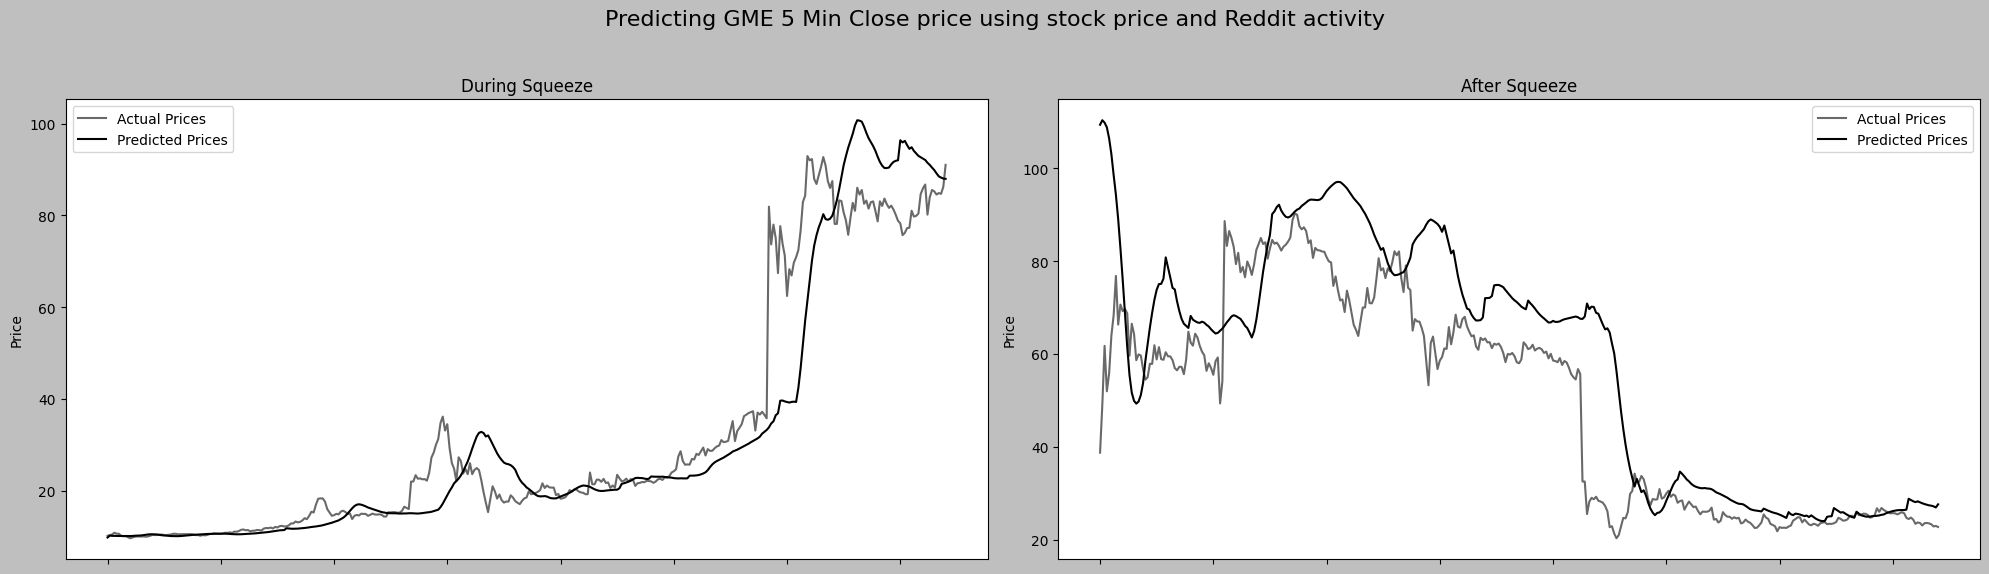

In [ ]:
# Test the model

print(f"Between {cut_off_1} and {cut_off_2}")
predicted_prices_original, actual_prices_original = test_model_multivariate(
        model, val_loader, seq_length, scaler_price, device)
predicted_prices_original = scaler_price.inverse_transform(predicted_prices_original.reshape(-1, 1)).flatten()
actual_prices_original    = scaler_price.inverse_transform(actual_prices_original.reshape(-1, 1)).flatten()


 # Test the model
print(f"After {cut_off_2}")
predicted_prices_original1, actual_prices_original1 = test_model_multivariate(
    model, test_loader, seq_length, scaler_price, device)
predicted_prices_original1 = scaler_price.inverse_transform(predicted_prices_original1.reshape(-1, 1)).flatten()
actual_prices_original1    = scaler_price.inverse_transform(actual_prices_original1.reshape(-1, 1)).flatten()


plt.style.use('grayscale')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(
    "Predicting GME 5 Min Close price using stock price and Reddit activity",
    fontsize=16
)

# Fig 1: During Squeeze (index on x‑axis)
axes[0].plot(actual_prices_original,    label="Actual Prices",    color="dimgray")
#axes[0].plot(np.arange(len(predicted_prices_original)) - 12,predicted_prices_original, label="Predicted Prices", color="black")
axes[0].plot(predicted_prices_original, label="Predicted Prices", color="black")
axes[0].set_title("During Squeeze")
axes[0].set_ylabel("Price")
axes[0].set_xticklabels([])
axes[0].legend()

# Fig 2: After Squeeze (index on x‑axis)
axes[1].plot(actual_prices_original1,    label="Actual Prices",    color="dimgray")
#axes[1].plot(np.arange(len(predicted_prices_original1)) - 12,predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].plot(predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].set_title("After Squeeze")
axes[1].set_ylabel("Price")
axes[1].set_xticklabels([])
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Prediction with Gemma Sentiment

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import random

def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}")

# Example: Setting the seed
set_seed(123)

def time_aware_r2(y_true, y_pred, start_t=12):
    assert len(y_true) == len(y_pred), "Lengths must match"

    model_sq_errors = []
    naive_sq_errors = []

    for t in range(start_t, len(y_true)):
        hist_mean = np.mean(y_true[:t])              # mean of past true values
        model_error = (y_true[t] - y_pred[t]) ** 2    # LSTM prediction error
        naive_error = (y_true[t] - hist_mean) ** 2    # historical mean error

        model_sq_errors.append(model_error)
        naive_sq_errors.append(naive_error)

    numerator = np.sum(model_sq_errors)
    denominator = np.sum(naive_sq_errors)

    if denominator == 0:
        return 0.0  # Avoid division by zero; degenerate case

    r2 = 1 - numerator / denominator
    return r2
# <|-----1hour stock price----|----1 hours reddit scores ------||--0hour--| => |-stock price after <2 hours-|

# Dataset class for stock prices and scores
class StockDatasetWithScores(Dataset):
    def __init__(self, data, seq_length=10):
        self.prices     = data['scaled_price'].values
        self.scores     = data['scaled_score'].values
        self.seq_length = seq_length

    def __len__(self):
        return len(self.prices) - self.seq_length - 12

    def __getitem__(self, idx):
        x_prices = self.prices[idx : idx + self.seq_length]
        x_scores = self.scores[idx + self.seq_length : idx + self.seq_length + 12]
        y        = (self.prices[idx + self.seq_length + 12])
        x        = (np.concatenate((x_scores, x_prices), axis=0))
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), []

# Preprocess data to merge stock prices and scores
def preprocess_data_with_scores(stock_sent_gemma_csv, cut_off_1, cut_off_2, test_one_start, test_two_end, seq_length=10):
    # Load stock prices
    merged_df = pd.read_csv(stock_sent_gemma_csv)

    # Scale stock prices and scores
    scaler_price = MinMaxScaler()
    scaler_score = MinMaxScaler()
    print(merged_df.columns)
    merged_df['scaled_price'] = scaler_price.fit_transform(merged_df[['GME_Close']])
    merged_df['scaled_score'] = scaler_score.fit_transform(merged_df[['Net_Sentiment_avg_5min']])

    # Split into training, validation, and testing
    train_data = merged_df[merged_df['DateTime'] < cut_off_1]
    val_data = merged_df[(merged_df['DateTime'] >= test_one_start) & (merged_df['DateTime'] < cut_off_2)]
    test_data = merged_df[(merged_df['DateTime'] >= cut_off_2) & (merged_df['DateTime'] < test_two_end)]

    # Create datasets
    train_dataset = StockDatasetWithScores(train_data, seq_length)
    val_dataset = StockDatasetWithScores(val_data, seq_length)
    test_dataset = StockDatasetWithScores(test_data, seq_length)

    return train_dataset, val_dataset, test_dataset, scaler_price, scaler_score

Seeds set to 123


In [ ]:
# Define the RNN model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # Use the last time step's output
        output = self.fc(output)
        return output


In [ ]:

# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    model.to(device)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.to(device), y.to(device)
                predictions = model(x)
                loss = criterion(predictions.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

In [ ]:
def test_model_multivariate(model, test_loader, seq_length, scaler, device='cpu'):
    model.to(device)
    model.eval()
    predictions = []
    actuals = []
    inputs = []

    with torch.no_grad():
        for x, y, norm in test_loader:
            x, y = x.to(device), y.to(device)
            predicted = model(x)
            predicted = predicted.squeeze().cpu().numpy()
            predictions.extend(predicted)
            actuals.extend(y.cpu().numpy())
            inputs.extend(x.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    predicted_prices_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual_prices_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

    mse = mean_squared_error(actual_prices_original, predicted_prices_original)
    mae = mean_absolute_error(actual_prices_original, predicted_prices_original)
    r2 = time_aware_r2(actual_prices_original, predicted_prices_original)

    print(f"Non-Autoregressive Test Metrics: MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    return predictions, actuals


In [ ]:
# Main script
if __name__ == "__main__":
    # File paths
    stock_sent_gemma_csv     = "drive/MyDrive/StockGME/Project_GME_Squeeze/5min_agg_gemma_sentiment_with_stock_price.csv"

    # Relevant cutoffs
    test_one_start= "2021-01-21 00:00:00"
    test_two_end  = "2021-02-04 00:00:00"

    cut_off_1     = "2021-01-21 00:00:00"
    cut_off_2     = "2021-01-28 00:00:00"

    # Hyperparameters
    seq_length    = 12
    batch_size    = 32
    learning_rate = 0.00001
    num_epochs    = 600
    device        = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Prepare datasets and dataloaders
    train_dataset, val_dataset, test_dataset, scaler_price, scaler_score = preprocess_data_with_scores(
        stock_sent_gemma_csv, cut_off_1, cut_off_2, test_one_start, test_two_end, seq_length)

    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, and optimizer
    model         = StockPriceRNN(input_size=1)  # Input size is 2: stock prices and scores
    criterion     = nn.MSELoss()
    optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and validate the model
    train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device)

    print(f"Between {cut_off_1} and {cut_off_2}")
    predicted_prices_original, actual_prices_original = test_model_multivariate(
        model, val_loader, seq_length, scaler_price, device)


    print(f"After {cut_off_2}")
    predicted_prices_original, actual_prices_original = test_model_multivariate(
        model, test_loader, seq_length, scaler_price, device)



Index(['DateTime', 'GME_Close', 'GME_5min_return', 'num_comments_5min',
       'score_max_5min', 'gme_timeline_mode_5min', 'Positive_avg_5min',
       'Negative_avg_5min', 'Neutral_avg_5min', 'Net_Sentiment_avg_5min'],
      dtype='object')
Epoch 1/600, Train Loss: 0.0017, Val Loss: 0.1160
Epoch 2/600, Train Loss: 0.0009, Val Loss: 0.1211
Epoch 3/600, Train Loss: 0.0006, Val Loss: 0.1251
Epoch 4/600, Train Loss: 0.0004, Val Loss: 0.1279
Epoch 5/600, Train Loss: 0.0003, Val Loss: 0.1294
Epoch 6/600, Train Loss: 0.0003, Val Loss: 0.1303
Epoch 7/600, Train Loss: 0.0003, Val Loss: 0.1307
Epoch 8/600, Train Loss: 0.0003, Val Loss: 0.1307
Epoch 9/600, Train Loss: 0.0003, Val Loss: 0.1307
Epoch 10/600, Train Loss: 0.0003, Val Loss: 0.1306
Epoch 11/600, Train Loss: 0.0003, Val Loss: 0.1305
Epoch 12/600, Train Loss: 0.0003, Val Loss: 0.1304
Epoch 13/600, Train Loss: 0.0003, Val Loss: 0.1302
Epoch 14/600, Train Loss: 0.0003, Val Loss: 0.1301
Epoch 15/600, Train Loss: 0.0003, Val Loss: 0.1300
Epo

Between 2021-01-21 00:00:00 and 2021-01-28 00:00:00
Non-Autoregressive Test Metrics: MSE: 116.9309, MAE: 5.8497, R^2: 0.8339
After 2021-01-28 00:00:00
Non-Autoregressive Test Metrics: MSE: 114.1397, MAE: 6.9491, R^2: 0.8023


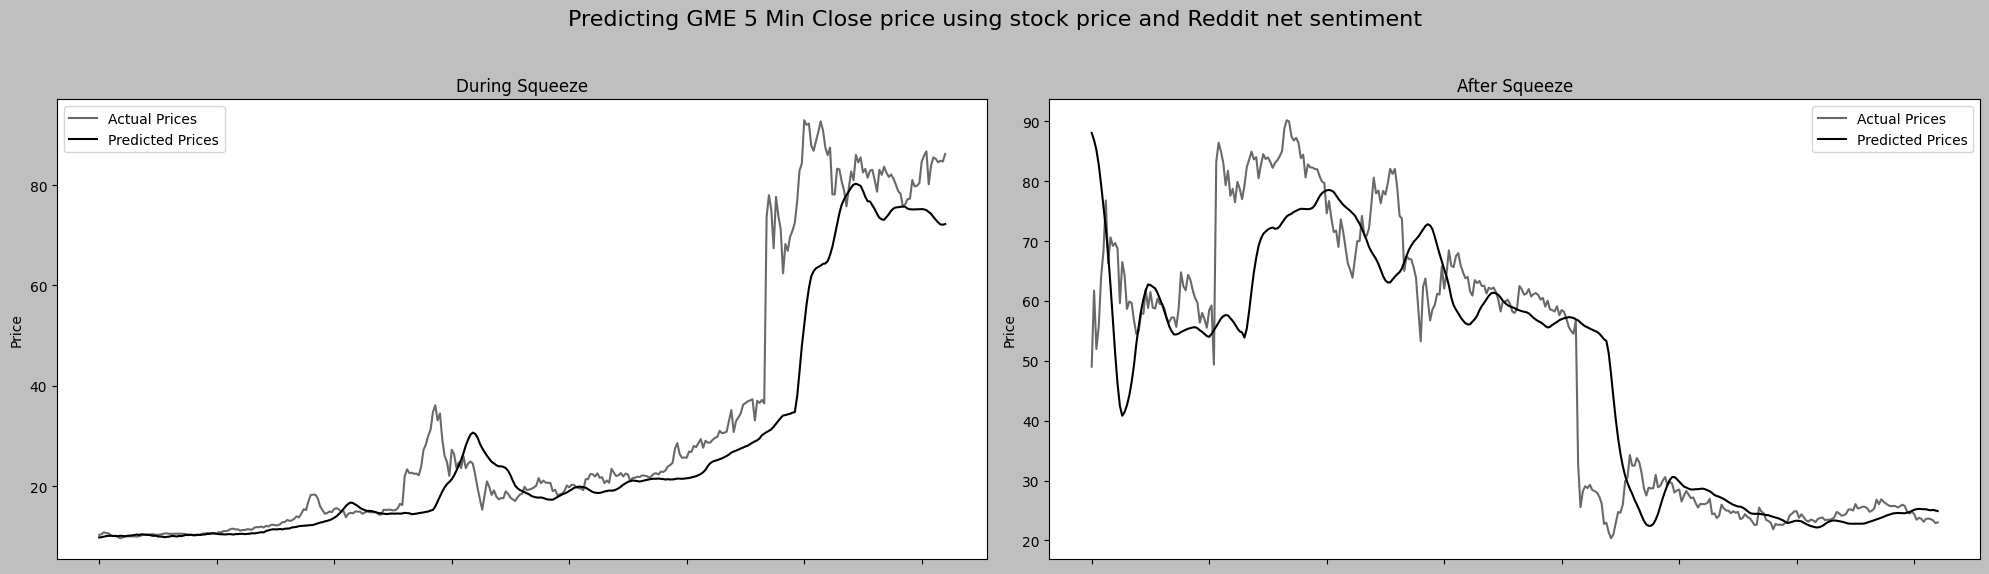

In [ ]:
# Test the model

print(f"Between {cut_off_1} and {cut_off_2}")
predicted_prices_original, actual_prices_original = test_model_multivariate(
        model, val_loader, seq_length, scaler_price, device)
predicted_prices_original = scaler_price.inverse_transform(predicted_prices_original.reshape(-1, 1)).flatten()
actual_prices_original    = scaler_price.inverse_transform(actual_prices_original.reshape(-1, 1)).flatten()


 # Test the model
print(f"After {cut_off_2}")
predicted_prices_original1, actual_prices_original1 = test_model_multivariate(
    model, test_loader, seq_length, scaler_price, device)
predicted_prices_original1 = scaler_price.inverse_transform(predicted_prices_original1.reshape(-1, 1)).flatten()
actual_prices_original1    = scaler_price.inverse_transform(actual_prices_original1.reshape(-1, 1)).flatten()


plt.style.use('grayscale')

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(
    "Predicting GME 5 Min Close price using stock price and Reddit net sentiment",
    fontsize=16
)

# Fig 1: During Squeeze (index on x‑axis)
axes[0].plot(actual_prices_original,    label="Actual Prices",    color="dimgray")
#axes[0].plot(np.arange(len(predicted_prices_original)) - 12,predicted_prices_original, label="Predicted Prices", color="black")
axes[0].plot(predicted_prices_original, label="Predicted Prices", color="black")
axes[0].set_title("During Squeeze")
axes[0].set_ylabel("Price")
axes[0].set_xticklabels([])
axes[0].legend()

# Fig 2: After Squeeze (index on x‑axis)
axes[1].plot(actual_prices_original1,    label="Actual Prices",    color="dimgray")
#axes[1].plot(np.arange(len(predicted_prices_original1)) - 12,predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].plot(predicted_prices_original1, label="Predicted Prices", color="black")
axes[1].set_title("After Squeeze")
axes[1].set_ylabel("Price")
axes[1].set_xticklabels([])
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
#plot